In [1]:
import os 
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numpy import dstack
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
from IPython.display import Image, display

GDRIVE_MOUNT_POINT = '/content/drive'
WORK_DIR = "/content/drive/MyDrive/work/Oliv"

MODEL_DIR = "/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/"

if not os.path.isdir(GDRIVE_MOUNT_POINT):
  drive.mount(GDRIVE_MOUNT_POINT)


Mounted at /content/drive


In [ ]:
list_genus=['Agaricus',
 'Amanita',
 'Armillaria',
 'Cortinarius',
 'Entoloma',
 'Gymnopus',
 'Hygrocybe',
 'Lactarius',
 'Marasmius',
 'Russula']

In [2]:
#Grad-CAM algorithm to obtain a class activation heatmap

def get_img_array(img_path, size):
    # `img` is a PIL image of size XxX
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (X, X, 3)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, X, X, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
    display(Image(cam_path))



In [108]:
#list all available h5 models in a main directory

def list_all_models(folder):
    all_models = {}
    filenames = []
    for root, dirs, files in os.walk(folder): 
        if ("0002/train/0001" in root):
            for i in files:
                full_name= os.path.join(root, i)
                root, extension = os.path.splitext(full_name)
                if extension==".h5": filenames.append(full_name) 
    for file in filenames:
        # add to list of members
        name = file.replace(folder, "")
        name = name.replace("/0002/train/0001/model/best_model.h5" , "")
        all_models[name]=file
    return all_models

all_models= list_all_models(MODEL_DIR)
all_models

{'efficientnetb0': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb0/0002/train/0001/model/best_model.h5',
 'efficientnetb1': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb1/0002/train/0001/model/best_model.h5',
 'efficientnetb2': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb2/0002/train/0001/model/best_model.h5',
 'efficientnetb3': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb3/0002/train/0001/model/best_model.h5',
 'efficientnetb4': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb4/0002/train/0001/model/best_model.h5',
 'efficientnetb5': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb5/0002/train/0001/model/best_model.h5',
 'efficientnetb6': '/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/efficientnetb6/0002/train/0001/model/best_model.h5',
 'efficientnetb7': '/content/drive/MyDriv

In [111]:
all_models.pop("xception")

'/content/drive/MyDrive/work/dad/output/classifier/multiclass/10/xception/0002/train/0001/model/best_model.h5'

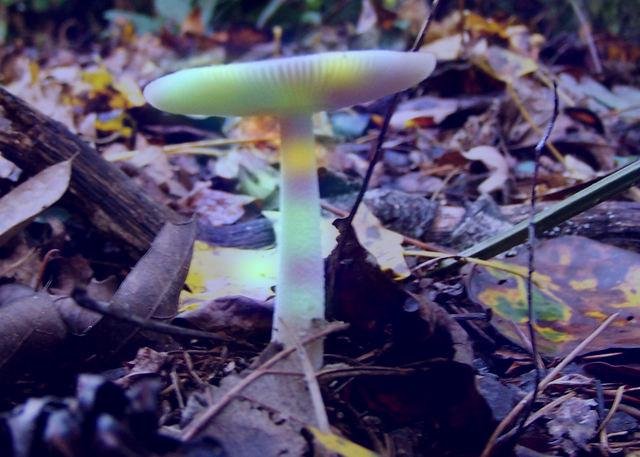

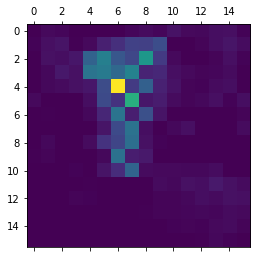

In [107]:
#Choose one picture
#Heatmap for one model (quicker)

#img_path= X_train["img_path"][105]
img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Hygrocybe/20292.jpg"
img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Amanita/7162.jpg"

#CHoose one model 
name = all_models["efficientnetb4"]

model= tf.keras.models.load_model(name)

#check for the latest convolution layer with a 4D output
for layer in reversed(model.layers):
    if len(layer.output_shape) ==4:
        last_conv_layer_name = layer.name
        break

# Prepare image
IMG_SIZE= model.input.get_shape().as_list()[1:3]
img_array = get_img_array(img_path, size=IMG_SIZE)

if "vgg16" in name:
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
elif "vgg19" in name:
    img_array = tf.keras.applications.vgg19.preprocess_input(img_array)
elif "xception" in name:
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
elif "mobilenetv2" in name:
    img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
elif "resnet50" in name:
    img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Remove last layer's softmax
#model.layers[-1].activation = None

# Print what the top predicted class is
preds = model.predict(img_array)
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# Display heatmap
plt.matshow(heatmap)

save_and_display_gradcam(img_path, heatmap)

> Analyzing  efficientnetb0
> Analyzing  efficientnetb1
> Analyzing  efficientnetb2
> Analyzing  efficientnetb3
> Analyzing  efficientnetb4
> Analyzing  efficientnetb5
> Analyzing  efficientnetb6
> Analyzing  efficientnetb7
> Analyzing  vgg16
> Analyzing  vgg19


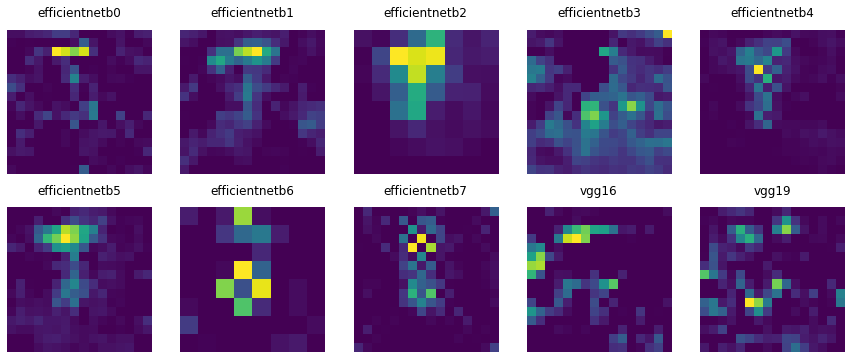

In [112]:
#Choose one picture
#heatmap for all models

#img_path= X_train["img_path"][105]
img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Hygrocybe/20292.jpg"
img_path= "/content/drive/MyDrive/work/Oliv/images_clean/Amanita/7162.jpg"

i=0
j=0
fig, ax = plt.subplots(2,5,figsize=(15,6))

for name, model in all_models.items():
    print("> Analyzing ", name)    
    model_analyzed = tf.keras.models.load_model(all_models[name])
    IMG_SIZE= model_analyzed.input.get_shape().as_list()[1:3]
    # Prepare image
    img_array = get_img_array(img_path, size=IMG_SIZE)

    if "vgg16" in name:
        img_array = tf.keras.applications.vgg16.preprocess_input(img_array)
    elif "vgg19" in name:
        img_array = tf.keras.applications.vgg19.preprocess_input(img_array)
    elif "xception" in name:
        img_array = tf.keras.applications.xception.preprocess_input(img_array)
    elif "mobilenetv2" in name:
        img_array = tf.keras.applications.mobilenet_v2.preprocess_input(img_array)
    elif "resnet50" in name:
        img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

    #check for the latest convolution layer with a 4D output
    for layer in reversed(model_analyzed.layers):
        if len(layer.output_shape) ==4:
            last_conv_layer_name = layer.name
            break

    # Remove last layer's softmax
    #model_analyzed.layers[-1].activation = None

    # Print what the top predicted class is
    #preds = model_analyzed.predict(img_array)
    #print("Predicted:", decode_predictions(preds, top=1)[0])

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(img_array, model_analyzed, last_conv_layer_name)

    ax[i,j].matshow(heatmap)
    ax[i,j].axis("off")
    ax[i,j].set_title(name)
    j+=1
    if j==5:
        i+=1
        j=0
